**Course website**: http://lagex.github.io/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Esse documento que você está usando é um [IPython notebook](http://ipython.org/notebook.html). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (que pode ser números, texto, figuras, videos, etc).

# Prática 3 - Ondas de superfície

Vamos utilizar as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

As tarefas abaixo acompanham as questões que vocês devem responder. Usem as simulações abaixo para te ajudar a responder as perguntas.

## Preparação

Rode a célula abaixo para carregar as componentes necessárias para fazer as simulações. Não se preocupe se aparecer um `:0: FutureWarning: IPython widgets are experimental and may change in the future.` abaixo. Isso é consequência de utilizar tecnologia de ponta.

In [215]:
%matplotlib inline
from __future__ import division
import numpy as np
from fatiando import utils
from fatiando.seismic.wavefd import Ricker, ElasticPSV, ElasticSH
import fatiando
import obspy
from obspy.fdsn import Client
from obspy.core.util.geodetics import gps2DistAzimuth, kilometer2degrees
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt
from IPython.html import widgets
from IPython.display import HTML
import numpy as np

## Sismogramas

Abaixo, vamos baixar os dados do [terremoto de Tohoku, Japão, de 2011](http://ds.iris.edu/ds/nodes/dmc/specialevents/2011/03/11/tohoku-japan-earthquake/). Esse sismograma foi registrado em uma estação no [Turquemenistão](https://www.google.com.br/maps/place/Turkmenistan/data=!4m2!3m1!1s0x3f65cb5574bc6ccb:0x7edd826b4169a491?sa=X&ei=TfhLVeCkNoa0ggSEuoG4Dw&ved=0CIYBEPIBMA8).

**Esses passos demostram como foram gerados os gráficos apresentados na aula e no questionário**. Não há componente de interatividade e não precisam ser rodados para responder as perguntas.

Primeiro, vamos baixar o registro do evento no catálogo do [IRIS](www.iris.edu/).

In [2]:
client = Client('IRIS')

In [3]:
# Terremoto de Tohoku, 25-04-2015
catalogo = client.get_events(eventid=3279407)

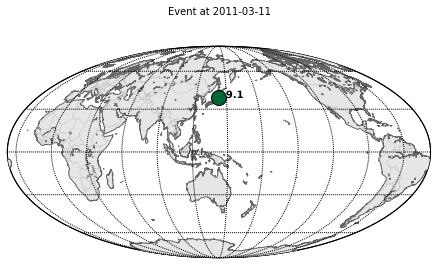

In [8]:
_ = catalogo.plot()

In [17]:
evento = catalogo[0]

Agora, vamos pegar as informações da estação no Turquemenistão.

In [9]:
# Alibek, Turkmenistan
station = client.get_stations(network='II', station='ABKT')[0][0]

In [10]:
station.latitude, station.longitude

(37.9304, 58.1189)

Finalmente, podemos baixar os sismogramas de 3 componentes do evento resitrado na estação.

In [11]:
t = obspy.UTCDateTime('2011-03-11 05:46:24')

In [12]:
data = client.get_waveforms('II', 'ABKT', '*', 'LH*', t, t + 1.6*3600)

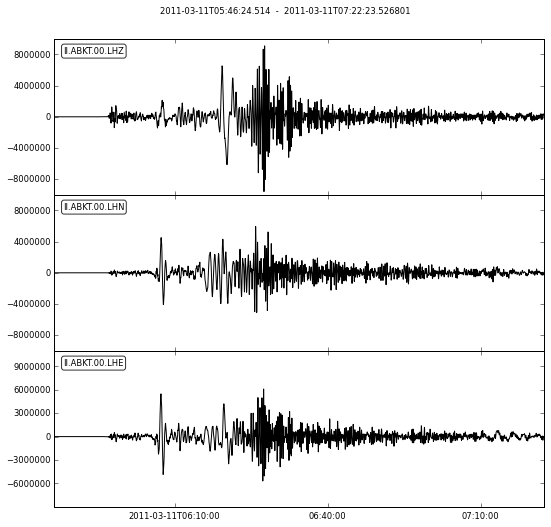

In [13]:
data.plot()

Esse sismograma precisa ser rotacionado para apontar na direção radial e transversal. Para isso, preciso calcular o azimute o evento em relação a estação.

In [20]:
event_lat = evento.origins[0].latitude
event_lon = evento.origins[0].longitude
dist, baz, _ = gps2DistAzimuth(station.latitude, station.longitude, 
                               event_lat, event_lon)
print("Azimute: {} graus\nDistancia: {} km".format(baz, dist/1000))

Azimute: 60.5072157163 graus
Distancia: 7110.56947547 km


In [21]:
rodado = data.copy()
rodado.rotate(method='NE->RT', back_azimuth=baz)

3 Trace(s) in Stream:
II.ABKT.00.LHT | 2011-03-11T05:46:24.514100Z - 2011-03-11T07:22:23.526801Z | 1.0 Hz, 5760 samples
II.ABKT.00.LHR | 2011-03-11T05:46:24.514100Z - 2011-03-11T07:22:23.526801Z | 1.0 Hz, 5760 samples
II.ABKT.00.LHZ | 2011-03-11T05:46:24.514000Z - 2011-03-11T07:22:23.526701Z | 1.0 Hz, 5760 samples

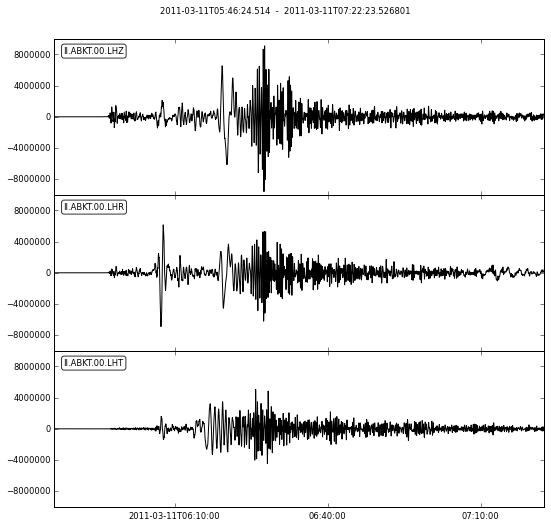

In [30]:
rodado.plot()
rodado.plot(outfile='sismograma-tohoku-tuquemenistao.jpg')

## Ondas Love

A simulação abaixo serve para mostrar como as reflexões e refrações de uma onda SH geram as ondas Love. Rode a célula abaixo para criar um modelo de velocidade da crosta e manto superior.

In [39]:
shape = (200, 1000)
spacing = 500
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]
densidade = np.ones(shape)*2700
velocidade = np.ones(shape)*3800
l1 = 40e3//spacing
densidade[l1:,:] = 3300
velocidade[l1:,:] = 5000

Agora vamos criar o nosso simulador de ondas.

In [40]:
sim1 = ElasticSH(velocidade, densidade, spacing=spacing, taper=0.005)

e colocar uma fonte explosiva em profundidade. Essa fonta não representa adequadamente um terremoto mas serivá para nossos propósitos.

In [41]:
f = 1
sim1.add_point_source((20e3//spacing, 50e3//spacing), Ricker(5, f, 1/f))

Agora que temos nossa simulação pronta, rode a célcula abaixo para avançar a simulação 400 passos no tempo.

In [60]:
sim1.run(2000)

|##################################################|100% Ran 2000 iterations in 70.7991 seconds.

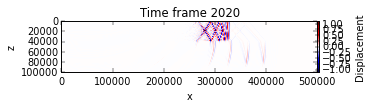

In [63]:
sim1.explore(every=20)

In [45]:
sim1.animate(every=20, embed=True, dpi=50, cutoff=0.5)

## Dispersão de ondas de superfície

Ondas de superfície são dispersivas. Isso quer dizer que diferentes frequências da onda viajam pela Terra com velocidades diferentes. Por isso, as diferentes frequências chegam defasadas nos sismômetros. Vamos ilustrar esse fato filtrando nosso sismograma para isolar uma única frequência. (Na verdade não podemos fazer isso exatamente. Separamos uma banda pequena de frequências.) Vamos usar períodos ao invés de frequências para ficar mais fácil.

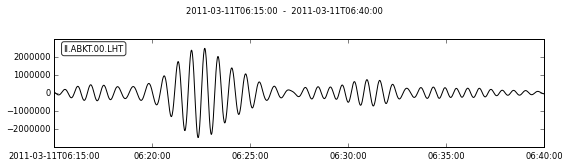

In [214]:
def bandpass(T):
    banda = 5
    f1 = 1/(T + banda)
    f2 = 1/(T - banda)
    t0 =  obspy.UTCDateTime('2011-03-11 06:15:00')
    tr = rodado[2].copy()
    #tr.trim(starttime=t0, endtime=t0 + 25*60)
    tr.filter('bandpass', freqmin=f1, freqmax=f2).plot(starttime=t0, endtime=t0 + 25*60)
    #plt.plot(tr.times(), tr.data, '-k')
    #plt.xlim(tr.times().min(), tr.times().max())
    #plt.ylim(-400e3, 400e3)
    
widgets.interactive(bandpass, T=widgets.IntSliderWidget(min=15, max=50, step=5, value=20))

## Modelagem direta da curva de dispersão

Agora vamos tentar modelar uma curva de dispersão de onda Love com uma camada sobre um meio semi-infinito. Essa curva de dispersão 

In [195]:
HTML('<iframe src="https://www.google.com/maps/d/embed?mid=zdRgD-zrdVfU.kbc3ccKBGJMw" width="640" height="480"></iframe>')

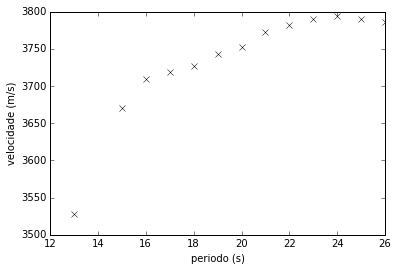

In [231]:
periodo, velocidade = np.loadtxt('../data/vel-grupo-sao-vicente.txt', unpack=True)
velocidade *= 1000
plt.plot(periodo, velocidade, 'xk')
plt.xlabel('periodo (s)')
plt.ylabel('velocidade (m/s)')

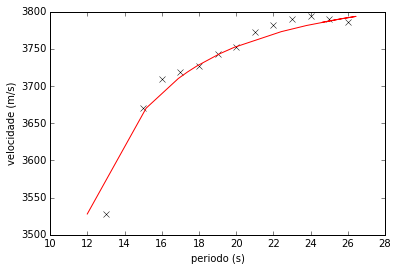

In [236]:
def modelagem(h, v1, v2, den1, den2):
    T = (2*np.pi*h*np.sqrt(velocidade**2/v1**2 - 1)/velocidade) \
        /np.arctan2(den2*np.sqrt(v2**4 - velocidade**2*v2**2),
                    den1*np.sqrt(velocidade**2*v1**2 - v1**4))
    plt.plot(periodo, velocidade, 'xk', T, velocidade, '-r')
    plt.xlabel('periodo (s)')
    plt.ylabel('velocidade (m/s)')
widgets.interactive(modelagem,
                    h=widgets.FloatSliderWidget(min=1000, max=60e3, step=100, value=5000),
                    v1=widgets.FloatSliderWidget(min=1000, max=5000, step=10, value=2300),
                    v2=widgets.FloatSliderWidget(min=1000, max=5000, step=10, value=3800),                    
                    den1=widgets.FloatSliderWidget(min=1000, max=4000, step=100, value=1900),                  
                    den2=widgets.FloatSliderWidget(min=1000, max=4000, step=100, value=2700))        